<a href="https://colab.research.google.com/github/javierFerreroM/NLP_Project/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se trata de un problema de clasificación multietiqueta en el que tenéis que etiquetar un conjunto de tweets de acuerdo a 11 sentimientos ('anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust').
Disponéis de un conjunto de 3561 tweets etiquetas para entrenar y validar el modelo o modelos necesarios, en el archivo 'sem_eval_train_es.csv'.

Cada alumno tiene que validar sus modelos sobre el conjunto ciego de test con el nombre 'sem_eval_test_blank_es.csv'. Cada Tweet tiene un ID (primera columna) que tenéis que mantener en vuestra solución. Debéis aplicar vuestro modelo entrenado a este conjunto y guardarlo en un archivo CSV de nombre 'soluciones_nombre_apellido1_apellido2.csv'. El archivo CSV a entregar debe tener esta estructura de Pandas:

<class 'pandas.core.frame.DataFrame'>  
RangeIndex: 679 entries, 0 to 678  
Data columns (total 12 columns):  

| #  | Column       |  Non-Null Count  | Dtype |  
|--- | ------       |  --------------  | ----- |  
 0   | ID            | 679 non-null    | object|
 1   | anger         | 679 non-null    | bool  |
 2   | anticipation  | 679 non-null    | bool  |
 3   | disgust       | 679 non-null    | bool  |
 4   | fear          | 679 non-null    | bool  |
 5   | joy           | 679 non-null    | bool  |
 6   | love          | 679 non-null    | bool  |
 7   | optimism      | 679 non-null    | bool  |
 8   | pessimism     | 679 non-null    | bool  |
 9   | sadness       | 679 non-null    | bool  |
 10  | surprise      | 679 non-null    | bool  |
 11  | trust         | 679 non-null    | bool  |
dtypes: bool(11), object(1)
Si el archivo no tiene exactamente esa estructura no se podrá evaluar.

Entrega:

Cada alumno deberá entregar a través de esta tarea habilitada en AV el archivo CSV de las predicciones en el conjunto ciego de test y todo el código en Python utilizado tanto para el entrenamiento de los modelos como la inferencia en el conjunto ciego de test. El código Python se entregará como Notebook de Jupyter.

In [80]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import re
from unidecode import unidecode
from keras.preprocessing.text import Tokenizer
import nltk 
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [82]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NLP/sem_eval_train_es.csv')
print("Training Set:"% train.columns, train.shape, len(train))
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NLP/sem_eval_test_blank_es.csv')
print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (3561, 13) 3561
Test Set: (679, 2) 679


Es siempre una buena idea limpiar los datos obtenidos. Debemos eliminar signos de puntuación para evitar introducir ruido en el entrenamiento, dado que símbolos de puntuación tales como @, #, !, etc.

Para ello, la biblioteca de python re nos va a permitir buscar expresiones regulares, para eliminar mayúsculas, etc

In [83]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [84]:
train.info

<bound method DataFrame.info of                  ID                                              Tweet  anger  \
0     2018-Es-01643  @aliciaenp Ajajjaa somos del clan twitteras pe...  False   
1     2018-Es-05142  @AwadaNai la mala suerte del gato fichame la c...  False   
2     2018-Es-05379  @audiomano A mí tampoco me agrado mucho eso. E...   True   
3     2018-Es-00208  Para llevar a los bebes de un lugar a otro deb...  False   
4     2018-Es-01385  @DalasReview me encanta la terrible hipocresia...   True   
...             ...                                                ...    ...   
3556  2018-Es-06340  Ahorita quisiera que mi preocupación más grand...  False   
3557  2018-Es-00439  El mayor criminal del país diciéndole “delincu...   True   
3558  2018-Es-04919  Mi prima de 4 años se ha enfadado conmigo porq...   True   
3559  2018-Es-02703                      @lennycia Jajaja...  Ya seee   False   
3560  2018-Es-02680  Quiero abrazar. Quiero querer. Me hace falta e...  False

In [85]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower() # pasar todo a minúsculas
    df[text_field] = df[text_field].apply(unidecode) # Eliminar los acentos y símbolos sobre las letras
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  # Eliminar caracteres extraños
    return df
test_clean = clean_text(test, "Tweet")
train_clean = clean_text(train, "Tweet")

In [86]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa ...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,la mala suerte del gato fichame la cara de he...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,a mi tampoco me agrado mucho eso especialment...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,me encanta la terrible hipocresia y doble mor...,True,False,True,False,False,False,False,False,False,False,False


In [87]:
# Check for null values
np.sum(train_clean.isnull().any(axis=1))

0

In [88]:
# Tokenizer: Split sentences into words
nltk.download('punkt')
train_clean['tokenized_sents'] = train_clean.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)
test_clean['tokenized_sents'] = test_clean.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'anger': 1155, 'anticipation': 415, 'disgust': 521, 'fear': 373, 'joy': 1087, 'love': 261, 'optimism': 378, 'pessimism': 578, 'sadness': 845, 'surprise': 169, 'trust': 175, 'tokenized_sents': 0}


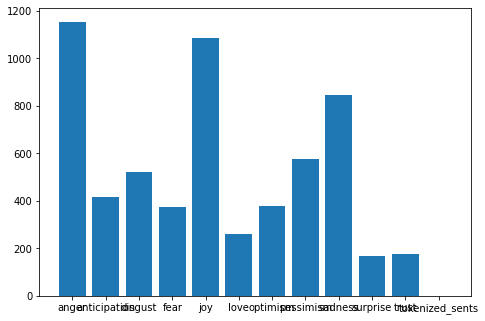

Count of columns in the data is:   14
Count of rows in the data is:   3561


In [89]:
#Check if the classes are imbalanced
count = {}
for i in train_clean.columns:
  if i not in ['ID', 'Tweet']:
    count[i] = len(train_clean[train_clean[i]==True])
print(count)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(count.keys(),count.values())
plt.show()
# Number of rows and columns
print('Count of columns in the data is:  ', len(train_clean.columns))
print('Count of rows in the data is:  ', len(train_clean))

In [90]:
train_clean.head(10)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,tokenized_sents
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa ...,False,False,False,False,True,False,False,False,False,False,False,"[ajajjaa, somos, del, clan, twitteras, perdida..."
1,2018-Es-05142,la mala suerte del gato fichame la cara de he...,False,False,False,True,False,False,False,True,False,False,False,"[la, mala, suerte, del, gato, fichame, la, car..."
2,2018-Es-05379,a mi tampoco me agrado mucho eso especialment...,True,False,False,False,False,False,False,False,False,False,False,"[a, mi, tampoco, me, agrado, mucho, eso, espec..."
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False,"[para, llevar, a, los, bebes, de, un, lugar, a..."
4,2018-Es-01385,me encanta la terrible hipocresia y doble mor...,True,False,True,False,False,False,False,False,False,False,False,"[me, encanta, la, terrible, hipocresia, y, dob..."
5,2018-Es-00089,en venezuela el trafico aereo esta tan peligro...,False,True,False,True,False,False,False,True,False,False,False,"[en, venezuela, el, trafico, aereo, esta, tan,..."
6,2018-Es-05189,me voy a morir sin saber por que y y me die...,False,False,False,True,False,False,False,False,True,False,False,"[me, voy, a, morir, sin, saber, por, que, y, y..."
7,2018-Es-02108,terrible esto,True,False,True,False,False,False,False,False,True,False,False,"[terrible, esto]"
8,2018-Es-00795,para tristeza y felicidad ed sheeran al rescate,False,False,False,False,True,False,False,False,True,False,False,"[para, tristeza, y, felicidad, ed, sheeran, al..."
9,2018-Es-02243,con razon mi vieja se fue rapido a santa fe si...,False,False,False,False,False,False,False,True,False,False,False,"[con, razon, mi, vieja, se, fue, rapido, a, sa..."


In [91]:
X = train_clean['tokenized_sents']
Y = train_clean[['anger',	'anticipation',	'disgust',	'fear', 'joy',	'love','optimism', 'pessimism',	'sadness',	'surprise','trust']]

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1)

In [93]:
Y_train

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
1784,False,False,False,True,False,False,False,True,True,False,False
2188,False,False,False,False,False,False,False,True,True,False,False
2136,True,False,False,False,False,False,False,False,False,False,False
846,True,False,False,False,True,False,False,False,False,False,False
2149,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2763,True,False,True,False,False,False,False,False,True,False,False
905,True,False,True,False,False,False,False,False,False,True,False
1096,False,False,False,False,True,False,True,False,False,False,False
235,False,False,False,False,True,False,False,False,False,False,True


Las columnas no son excluyentes. Cada tweet puede ser de más de un tipo de sentimiento. Por tanto, no es posible balancear el dataset.

Con los datos ya tratados y listos, podemos empezar el entrenamiento

In [94]:
# Compare the models
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [95]:
# 5 Cross-validation
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [96]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, Y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
TypeError: float() argument must be a string or a number, not 'list'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 328, in fit
    X, y, multi_output=True, accept_sparse="csc", dtype=DTYPE
  File "/usr/local/lib/py

In [97]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,NaN,NaN
LogisticRegression,NaN,NaN
MultinomialNB,NaN,NaN
RandomForestClassifier,NaN,NaN


In [98]:

model = LinearSVC()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

# Classification report
print('ttttCLASSIFICATIION METRICSn')
print(metrics.classification_report(Y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

ValueError: ignored

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);

In [ ]:
y_test = model.predict(test_clear)